In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sn

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_39725/4205361466.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df['Close'].resample('M').last()


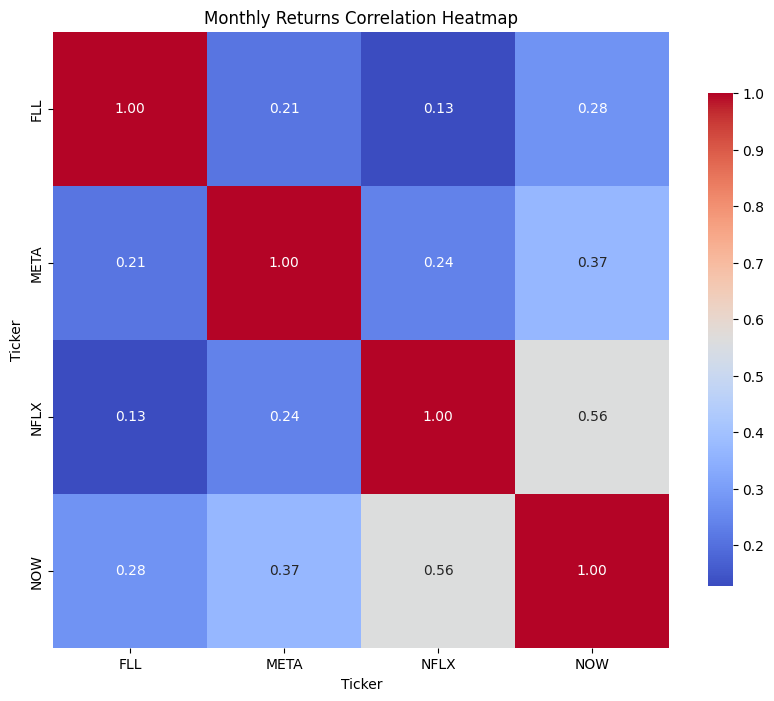

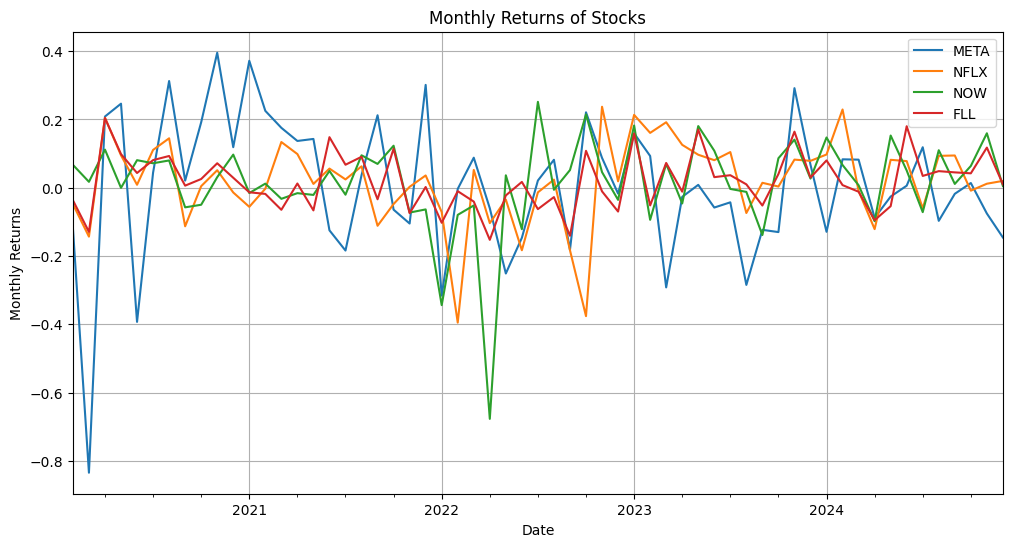

In [4]:
#import all 4 stocks 

stocks = ['META', 'NFLX', 'NOW', 'FLL']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')
# Resample to monthly frequency
df = df['Close'].resample('M').last()
# Calculate monthly returns
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
#plot the heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(monthly_returns.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Monthly Returns Correlation Heatmap')
plt.show()

#plot the returns of each stock
log_returns.plot(figsize=(12, 6))
plt.title('Monthly Returns of Stocks')
plt.xlabel('Date')
plt.ylabel('Monthly Returns')
plt.legend(stocks)
plt.grid()
plt.show()

[*********************100%***********************]  4 of 4 completed
/var/folders/b1/p4nglr2j4tldllw81z_d3c4c0000gn/T/ipykernel_39725/710475586.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df = df.resample('M').last()


Mean Squared Error: 0.0320


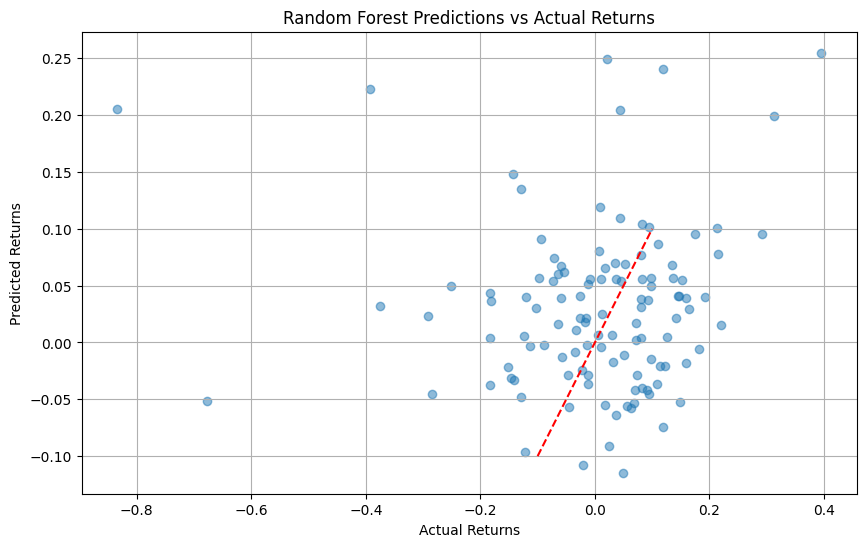

Ticker       FLL      META      NFLX       NOW
Date                                          
2      -0.033858  0.062614 -0.029797 -0.003707
3      -0.042125  0.056930 -0.026860 -0.001609
4      -0.035046  0.053671 -0.028193 -0.005208
5      -0.027866  0.060950 -0.014141  0.003077
6      -0.034490  0.050673 -0.034480 -0.009614
7       0.020762  0.096368 -0.005263  0.002741
8       0.033440  0.096311  0.003533  0.009250
9       0.030946  0.103141  0.011676  0.024795
10      0.071600  0.093503  0.026032  0.026864
11      0.061379  0.091188  0.017979  0.039203
12      0.014552  0.071494 -0.020752  0.031494


<Figure size 1200x600 with 0 Axes>

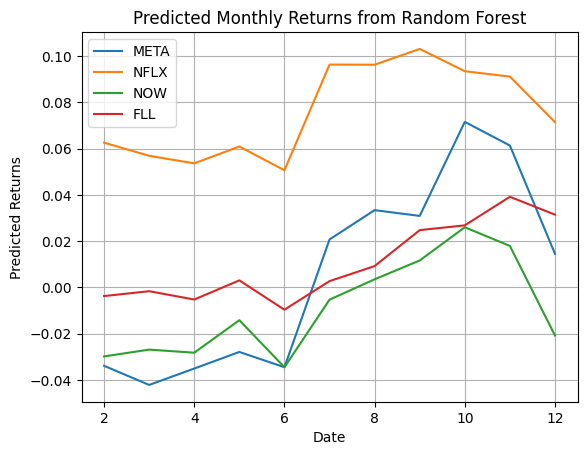

In [5]:
#set random forest parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Prepare the data for Random Forest

stocks = ['META', 'NFLX', 'NOW', 'FLL']
df = yf.download(stocks, start='2020-01-01', end='2025-01-01')['Close']
df = df.resample('M').last()
monthly_returns = df.pct_change().dropna()
log_returns = np.log(monthly_returns + 1)
price_series = df

X = price_series.shift(1).dropna().values
y = log_returns.shift(-1).dropna().values

# realigning matrices
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
# Make predictions
y_pred = rf_model.predict(X_test)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
# Plot the predictions vs actual returns
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Random Forest Predictions vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()
plt.show()

#get predicted pooled returns
price_series_aggregated = price_series.groupby(price_series.index.month).mean()

predicted_returns = rf_model.predict(price_series_aggregated.shift(1).dropna().values)

# Align predicted returns with the correct index and columns
predicted_returns = pd.DataFrame(predicted_returns, index=price_series_aggregated.index[1:], columns=price_series.columns)
print(predicted_returns)
plt.figure(figsize=(12, 6))
predicted_returns.plot()
plt.title('Predicted Monthly Returns from Random Forest')
plt.xlabel('Date')
plt.ylabel('Predicted Returns')
plt.legend(stocks)
plt.grid()
plt.show()


Feature Importances (sorted):
  Stock  Importance
0   FLL    0.527388
1  META    0.165541
2  NFLX    0.162031
3   NOW    0.145040


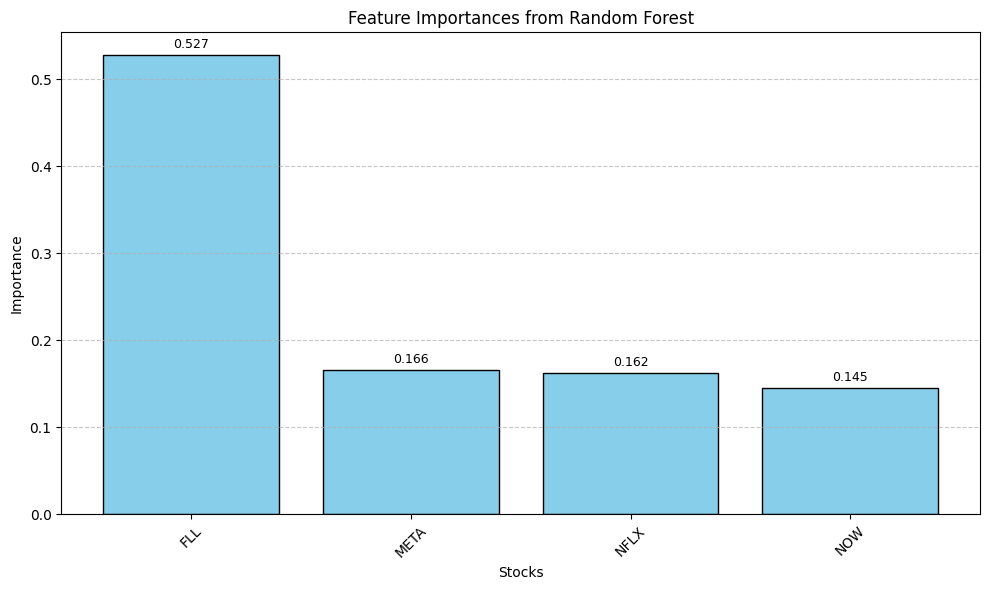

In [22]:
# Improved feature importance matrix visualization and debug output

importances = rf_model.feature_importances_
feature_names = price_series.columns

# Create a DataFrame for better inspection and sorting
importance_df = pd.DataFrame({
    'Stock': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the importance matrix for debugging
print("Feature Importances (sorted):")
print(importance_df)

# Enhanced bar plot with value annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(importance_df['Stock'], importance_df['Importance'], color='skyblue', edgecolor='black')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Stocks')
plt.ylabel('Importance')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with importance values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (Neural Network): 0.2955


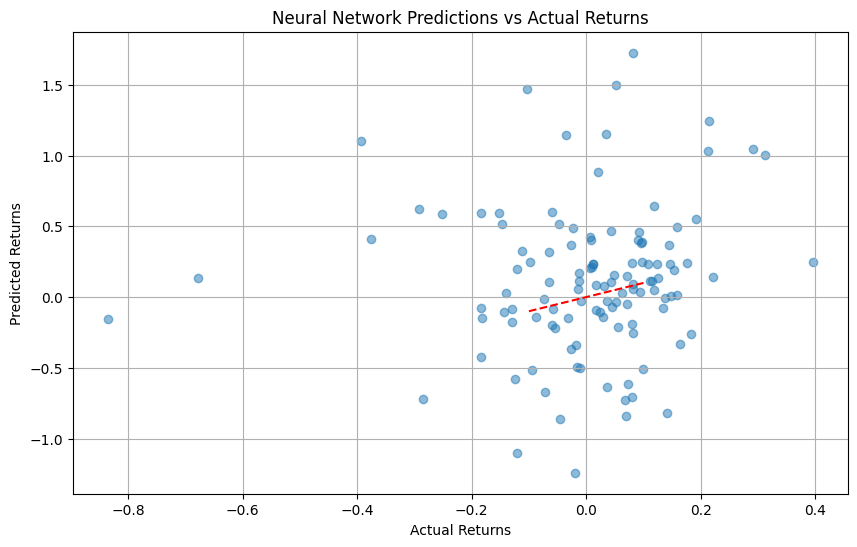

In [7]:
#set neural netwwork with parameteres to get arbitrage period which shows price spike 
from sklearn.neural_network import MLPRegressor
# Prepare the data for Neural Network
X_nn = price_series.shift(1).dropna().values
y_nn = log_returns.shift(-1).dropna().values
# Realigning matrices
min_length_nn = min(len(X_nn), len(y_nn))
X_nn = X_nn[:min_length_nn]
y_nn = y_nn[:min_length_nn]
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
	X_nn, y_nn, test_size=0.5, random_state=42
)
# Train the Neural Network model
nn_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=0)
nn_model.fit(X_train_nn, y_train_nn)
# Make predictions
y_pred_nn = nn_model.predict(X_test_nn)
# Calculate the mean squared error
mse_nn = mean_squared_error(y_test_nn, y_pred_nn)
print(f'Mean Squared Error (Neural Network): {mse_nn:.4f}')
# Plot the predictions vs actual returns
plt.figure(figsize=(10, 6))
plt.scatter(y_test_nn, y_pred_nn, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Neural Network Predictions vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()
plt.show()

In [8]:
#Set optimal portfolio weights based on the predicted returns USING MARKOVITZ
from scipy.optimize import minimize

muh = price_series.mean()
sigma = price_series.cov()
def portfolio_variance(weights, sigma):
    return np.dot(weights.T, np.dot(sigma, weights))

weights_initial = np.array([1/len(stocks)] * len(stocks))
def objective_function(weights, mu, sigma):
    return -np.dot(weights, mu) / np.sqrt(portfolio_variance(weights, sigma)) #muh*weight/sigma
def constraint_sum(weights):
    return np.sum(weights) - 1
# Constraints and bounds
constraints = {'type': 'eq', 'fun': constraint_sum}
bounds = tuple((0, 1) for _ in range(len(stocks)))
# Optimize the portfolio weights
result = minimize(objective_function, weights_initial, args=(muh, sigma), method='SLSQP', bounds=bounds, constraints=constraints) #Assign convex optimiser
optimal_weights = result.x
print(f'Optimal Weights: {optimal_weights}')
#print stock names and their corresponding weights
for stock, weight in zip(stocks, optimal_weights):
    print(f'{stock}: {weight:.4f}')

Optimal Weights: [9.74829890e-01 3.49281252e-13 1.07506477e-02 1.44194623e-02]
META: 0.9748
NFLX: 0.0000
NOW: 0.0108
FLL: 0.0144


[*********************100%***********************]  4 of 4 completed


=== Enhanced Neural Network with Politician Parameters ===
Features per stock: 7 (3 price periods + 4 politician parameters)
Total training samples: 82
Total test samples: 36
Enhanced MLP Train R²: 0.0413
Enhanced MLP Test R²: -0.2052

=== Comparison with Baseline Model ===
Baseline MLP Train R²: -0.0693
Baseline MLP Test R²: -0.0723
Improvement in Test R²: -0.1329

=== Politician Parameter Analysis ===
Politician encodings:
  John McGuire: 0
  Susie Lee: 1

Party encodings:
  Democratic: 0
  Republican: 1

Sector encodings:
  Gaming: 0
  Technology: 1

Volume encodings:
  1K-5K: 0
  Low: 1


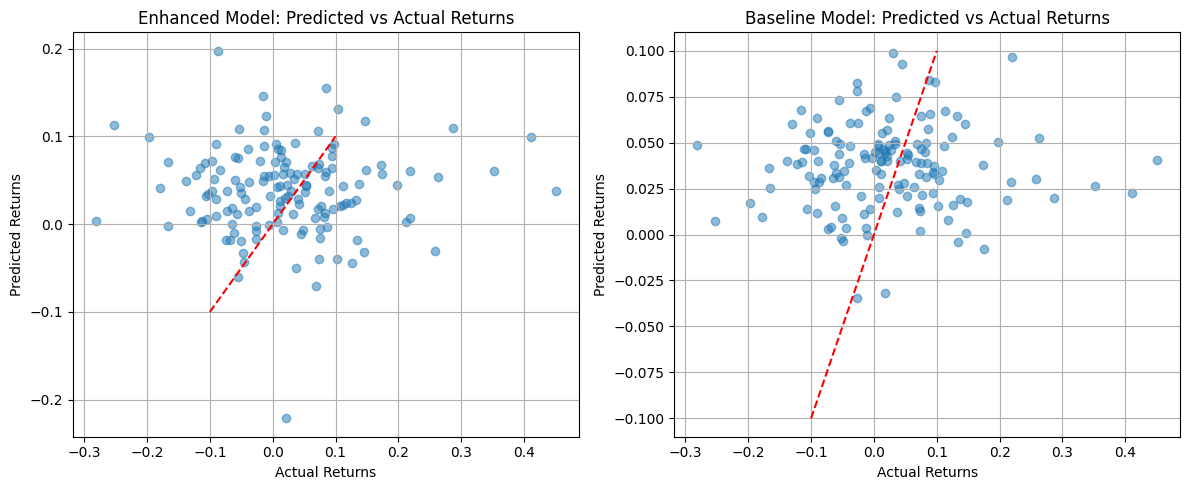


=== Next Period Predictions with Politician Context ===
META (John McGuire, Republican, Technology): 0.0294
NFLX (John McGuire, Republican, Technology): -0.0044
NOW (John McGuire, Republican, Technology): 0.0298
FLL (Susie Lee, Democratic, Gaming): 0.0435

=== Cross-Validation Results ===
Cross-validation R² scores: ['0.0003', '-0.5009', '-0.3229', '-0.6625', '-0.3425']
Mean CV R²: -0.3657 ± 0.2203


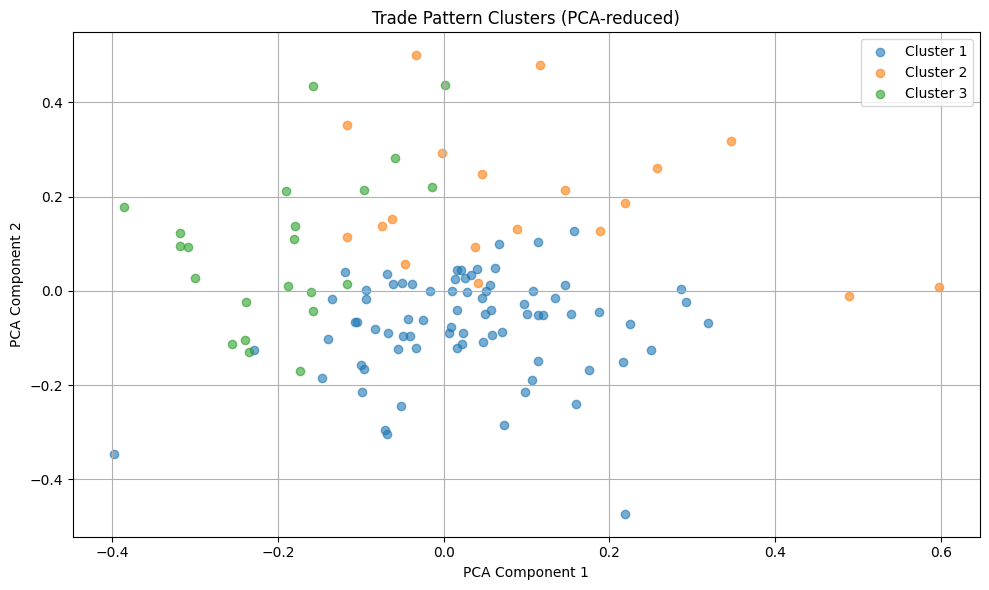


=== Cluster Composition by Time Period ===
Cluster 1: 77 samples
Cluster 2: 19 samples
Cluster 3: 22 samples

Cluster 1 mean returns per stock:
  META: 0.0123
  NFLX: 0.0099
  NOW: 0.0295
  FLL: 0.0260

Cluster 2 mean returns per stock:
  META: -0.0143
  NFLX: 0.0207
  NOW: 0.0348
  FLL: 0.0191

Cluster 3 mean returns per stock:
  META: 0.0857
  NFLX: 0.0653
  NOW: 0.0250
  FLL: 0.0335


In [21]:
# Incorporate all politician parameters into neural network
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np

# Define stock information with politician parameters
stock_info_dictionary = {
    'META': {'politician': 'John McGuire', 'party': 'Republican', 'sector': 'Technology', 'volume': '1K-5K'},
    'NFLX': {'politician': 'John McGuire', 'party': 'Republican', 'sector': 'Technology', 'volume': '1K-5K'}, #add dates traded
    'NOW': {'politician': 'John McGuire', 'party': 'Republican', 'sector': 'Technology', 'volume': '1K-5K'},
    'FLL': {'politician': 'Susie Lee', 'party': 'Democratic', 'sector': 'Gaming', 'volume': 'Low'}
}

# Download and preprocess stock data
df = yf.download(stocks, start='2015-01-01', end='2025-01-01')['Close'].resample('ME').last()
price_series = df.pct_change().dropna()

# Create politician parameter encoders
politician_encoder = LabelEncoder()
party_encoder = LabelEncoder()
sector_encoder = LabelEncoder()
volume_encoder = LabelEncoder()

# Extract unique values for encoding
politicians = [info['politician'] for info in stock_info_dictionary.values()]
parties = [info['party'] for info in stock_info_dictionary.values()]
sectors = [info['sector'] for info in stock_info_dictionary.values()]
volumes = [info['volume'] for info in stock_info_dictionary.values()]

# Fit encoders
politician_encoder.fit(politicians)
party_encoder.fit(parties)
sector_encoder.fit(sectors)
volume_encoder.fit(volumes)

# Create enhanced feature matrix with politician parameters
def create_enhanced_features(price_data, stock_info_dict):
    """
    Create enhanced feature matrix combining stock price data with politician parameters
    """
    enhanced_features = []
    
    for stock in price_data.columns:
        if stock in stock_info_dict:
            # Get politician info for this stock
            info = stock_info_dict[stock]
            
            # Encode politician parameters
            politician_encoded = politician_encoder.transform([info['politician']])[0]
            party_encoded = party_encoder.transform([info['party']])[0]
            sector_encoded = sector_encoder.transform([info['sector']])[0]
            volume_encoded = volume_encoder.transform([info['volume']])[0]
            
            # Create feature vector for each time period
            for i in range(len(price_data)):
                # Stock price features (last 3 periods for trend)
                price_features = []
                for j in range(3):
                    if i - j >= 0:
                        price_features.append(price_data.iloc[i-j][stock])
                    else:
                        price_features.append(0)  # Padding for early periods
                
                # Combine price features with politician features
                combined_features = price_features + [
                    politician_encoded,
                    party_encoded, 
                    sector_encoded,
                    volume_encoded
                ]
                
                enhanced_features.append(combined_features)
    
    return np.array(enhanced_features)

# Create enhanced features
X_enhanced = create_enhanced_features(price_series, stock_info_dictionary)

# Prepare target variable (next period returns)
y_enhanced = price_series.values[1:]  # Shift by 1 to predict next period
X_enhanced = X_enhanced[:-1]  # Remove last row since we don't have next period data

# Ensure same length
min_length = min(len(X_enhanced), len(y_enhanced))
X_enhanced = X_enhanced[:min_length]
y_enhanced = y_enhanced[:min_length]

# Split data
X_train_enhanced, X_test_enhanced, y_train_enhanced, y_test_enhanced = train_test_split(
    X_enhanced, y_enhanced, test_size=0.3, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enhanced)
X_test_scaled = scaler.transform(X_test_enhanced)

# Train enhanced neural network
mlp_enhanced = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32), 
    activation='relu', 
    solver='adam', 
    max_iter=1000, 
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

mlp_enhanced.fit(X_train_scaled, y_train_enhanced)

# Evaluate enhanced model
train_score_enhanced = mlp_enhanced.score(X_train_scaled, y_train_enhanced)
test_score_enhanced = mlp_enhanced.score(X_test_scaled, y_test_enhanced)

print("=== Enhanced Neural Network with Politician Parameters ===")
print(f"Features per stock: {X_enhanced.shape[1]} (3 price periods + 4 politician parameters)")
print(f"Total training samples: {X_train_enhanced.shape[0]}")
print(f"Total test samples: {X_test_enhanced.shape[0]}")
print(f"Enhanced MLP Train R²: {train_score_enhanced:.4f}")
print(f"Enhanced MLP Test R²: {test_score_enhanced:.4f}")

# Compare with baseline model (price data only)
X_baseline = price_series.shift(1).dropna().values
y_baseline = price_series.iloc[1:].values

X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.3, random_state=42
)

mlp_baseline = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_baseline.fit(X_train_baseline, y_train_baseline)

baseline_train_score = mlp_baseline.score(X_train_baseline, y_train_baseline)
baseline_test_score = mlp_baseline.score(X_test_baseline, y_test_baseline)

print("\n=== Comparison with Baseline Model ===")
print(f"Baseline MLP Train R²: {baseline_train_score:.4f}")
print(f"Baseline MLP Test R²: {baseline_test_score:.4f}")
print(f"Improvement in Test R²: {test_score_enhanced - baseline_test_score:.4f}")

# Feature importance analysis for politician parameters
print("\n=== Politician Parameter Analysis ===")
print("Politician encodings:")
for i, politician in enumerate(politician_encoder.classes_):
    print(f"  {politician}: {i}")

print("\nParty encodings:")
for i, party in enumerate(party_encoder.classes_):
    print(f"  {party}: {i}")

print("\nSector encodings:")
for i, sector in enumerate(sector_encoder.classes_):
    print(f"  {sector}: {i}")

print("\nVolume encodings:")
for i, volume in enumerate(volume_encoder.classes_):
    print(f"  {volume}: {i}")

# Plot predictions vs actual returns for enhanced model
predicted_enhanced = mlp_enhanced.predict(X_test_scaled)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_enhanced.flatten(), predicted_enhanced.flatten(), alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Enhanced Model: Predicted vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()

plt.subplot(1, 2, 2)
predicted_baseline = mlp_baseline.predict(X_test_baseline)
plt.scatter(y_test_baseline.flatten(), predicted_baseline.flatten(), alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], color='red', linestyle='--')
plt.title('Baseline Model: Predicted vs Actual Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.grid()

plt.tight_layout()
plt.show()

# Predict next period returns with politician context
print("\n=== Next Period Predictions with Politician Context ===")
latest_features = X_enhanced[-1:]  # Get latest features
latest_features_scaled = scaler.transform(latest_features)
next_predictions = mlp_enhanced.predict(latest_features_scaled)

for i, stock in enumerate(stocks):
    if stock in stock_info_dictionary:
        info = stock_info_dictionary[stock]
        print(f"{stock} ({info['politician']}, {info['party']}, {info['sector']}): {next_predictions[0][i]:.4f}")
    else:
        print(f"{stock}: {next_predictions[0][i]:.4f}")

# Cross-validation with politician parameters
print("\n=== Cross-Validation Results ===")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(X_enhanced):
    X_cv_train, X_cv_val = X_enhanced[train_idx], X_enhanced[val_idx]
    y_cv_train, y_cv_val = y_enhanced[train_idx], y_enhanced[val_idx]
    
    # Scale features
    cv_scaler = StandardScaler()
    X_cv_train_scaled = cv_scaler.fit_transform(X_cv_train)
    X_cv_val_scaled = cv_scaler.transform(X_cv_val)
    
    # Train model
    cv_model = MLPRegressor(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42)
    cv_model.fit(X_cv_train_scaled, y_cv_train)
    
    # Evaluate
    cv_score = cv_model.score(X_cv_val_scaled, y_cv_val)
    cv_scores.append(cv_score)

print(f"Cross-validation R² scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean CV R²: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")




# apply clustering to get trade patterns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# We'll use the enhanced features (with politician context) for clustering
n_clusters = 3  # You can adjust this based on your analysis

# Reduce dimensionality for visualization (optional, but helpful)
#define PCA components
n_components = 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_enhanced)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_enhanced)

# Visualize clusters in PCA-reduced space
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    plt.scatter(
        X_pca[clusters == cluster, 0],
        X_pca[clusters == cluster, 1],
        label=f'Cluster {cluster+1}',
        alpha=0.6
    )
plt.title('Trade Pattern Clusters (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Analyze cluster composition
import collections
print("\n=== Cluster Composition by Time Period ===")
cluster_counts = collections.Counter(clusters)
for cluster in range(n_clusters):
    print(f"Cluster {cluster+1}: {cluster_counts[cluster]} samples")

# Optionally, examine average returns per cluster
cluster_returns = []
for cluster in range(n_clusters):
    mean_return = y_enhanced[clusters == cluster].mean(axis=0)
    cluster_returns.append(mean_return)
    print(f"\nCluster {cluster+1} mean returns per stock:")
    for i, stock in enumerate(stocks):
        print(f"  {stock}: {mean_return[i]:.4f}")
